In [1]:
from bs4 import BeautifulSoup
import requests
import multiprocessing as mp
import pandas as pd
import re
from nltk.stem import RSLPStemmer
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [ ]:
def getPage(url):
    html = requests.get(url).content
    soup = BeautifulSoup(html, 'html.parser')
    links = soup.findAll('a', {'class': 'feed-post-link gui-color-primary gui-color-hover'})
    print( 'processed page'  + url)
    return list(dict.fromkeys([link.get('href') for link in links if link.text != None and link.get('href') != None]))

In [ ]:
def get_true_and_text(url): 
    try:
        resp = requests.get(url)
        if(resp.status_code != 200):
            raise Exception('Error executing http call')

        html = resp.content
        soup = BeautifulSoup(html, 'html.parser')
        text = soup.find('h2', {'class': 'content-head__subtitle'}).text
        
        return (True, text)
    except Exception as e:
        print('##### ERROR - ' + str(e))
        return (None, None)

In [ ]:
base_url = "https://g1.globo.com/index/feed/pagina-{0}.ghtml"
pool = mp.Pool(mp.cpu_count())

v_links = []
pages = []
for i in range(1, 150):
    pages.append(base_url.format(i))

results = [pool.apply(getPage, args=((p,))) for p in pages]
pool.close()  
[v_links.extend(r) for r in results]
v_links = list(dict.fromkeys(v_links))

In [6]:
df = pd.DataFrame(v_links)
df.to_csv('generated/g1_verified_links.csv', index=False)

In [ ]:
pool = mp.Pool(mp.cpu_count())
results_get_fake = [pool.apply(get_true_and_text, args=((p,))) for p in v_links]
pool.close()  

df = pd.DataFrame(results_get_fake)
df.to_csv('generated/results_get_real.csv', index=False)

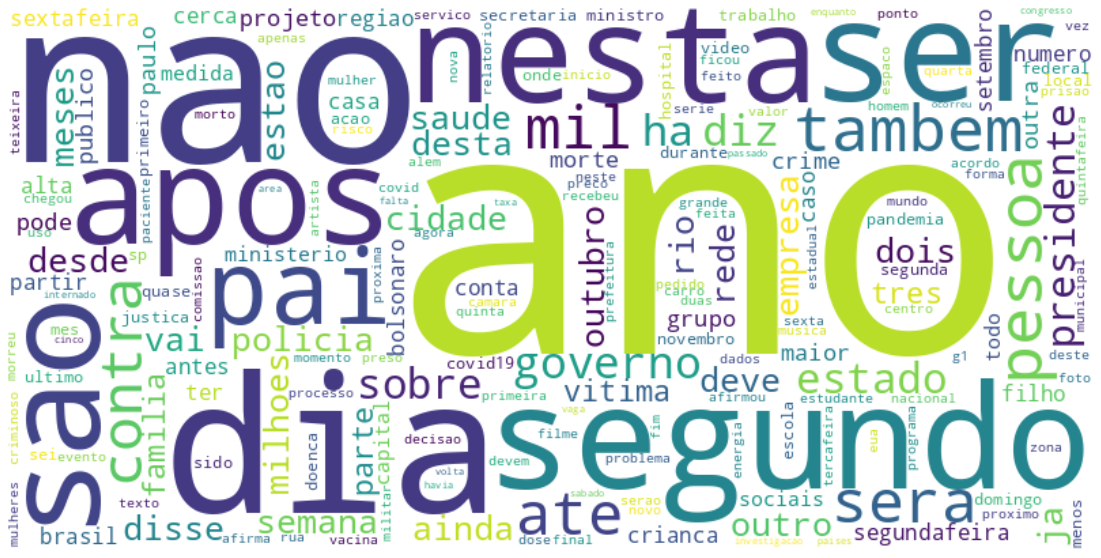

In [4]:
df = pd.read_csv('generated/results_get_real.csv')
df['1'] = df['1'].astype(str)

remove_pontuacao = lambda x:  re.sub(r'[^\w\s]', '', x)
remove_quebra_linha = lambda x:  re.sub(r'\\n', ' ', x)
remove_tabulacao = lambda x:  re.sub(r'\\t', ' ', x)
remove_multiplos_espacos = lambda x:  re.sub(' +', ' ', x)

stemmer = RSLPStemmer()
stopws = stopwords.words('portuguese')

df['1'] = df['1'].map(remove_quebra_linha).map(remove_tabulacao).map(remove_multiplos_espacos).map(remove_pontuacao)

df['1'] = df['1'].str.lower()
df['1'] = df['1'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df['1'] = df['1'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopws)]))
df['1'] = df['1'].str.strip()

df.replace('', None, inplace=True)
df.drop_duplicates(subset='1', keep='last', inplace=True)
df.dropna(inplace=True)
df['1'] = df['1'].str.lower()
df['1'] = df['1'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

words = " ".join(df['1'])
word_cloud = WordCloud(width=800, height=400, collocations = False, background_color = 'white').generate(words)
plt.figure( figsize=(20,10) )
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

df['1'] = df['1'].apply(lambda x: ' '.join([stemmer.stem(y) for y in x.split(' ')]))
df.to_csv('generated/results_get_real_built.csv', index=False)